In [28]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
reps = 1
ncities = 4

In [3]:
G = create_tsp_graph(ncities)

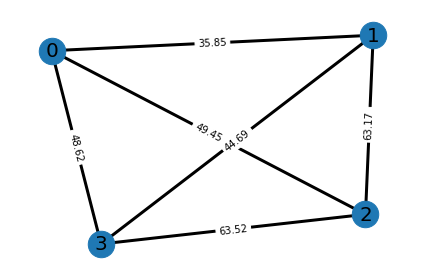

In [4]:
plot_tsp_graph(G)

In [27]:
expectation = get_expectation(G,reps,shots=1024,log_intermediate_counts=True)

res = minimize(expectation,
               [1 for _ in range(reps*4)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 203.69
Current expected cost: 203.69
Current expected cost: 203.69
Current expected cost: 207.75
Current expected cost: 203.69
Current expected cost: 211.16
Current expected cost: 208.42
Current expected cost: 203.41
Current expected cost: 203.39
Current expected cost: 203.39
Current expected cost: 204.3
Current expected cost: 203.39
Current expected cost: 205.29
Current expected cost: 204.1
Current expected cost: 203.89
Current expected cost: 209.24
Current expected cost: 207.12
Current expected cost: 209.32
Current expected cost: 203.39
Current expected cost: 210.6
Current expected cost: 203.39
Current expected cost: 209.29
Current expected cost: 206.73
Current expected cost: 203.56
Current expected cost: 210.13
Current expected cost: 207.17
Current expected cost: 203.71
Current expected cost: 203.39
Current expected cost: 205.17
Current expected cost: 203.39
Current expected cost: 203.45
Current expected cost: 204.34
Current expected cost: 203.46
Current expec

In [6]:
res

     fun: 203.22768057626618
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([0.99999679, 0.9999995 , 1.49961167, 0.9999995 ])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


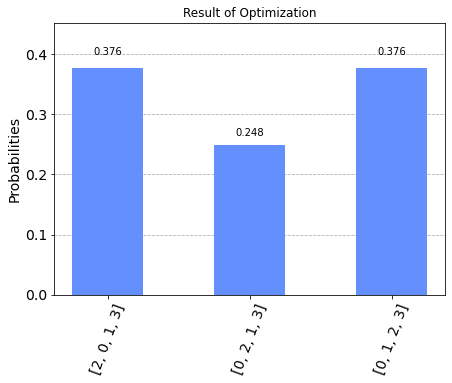

In [7]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

In [8]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[0, 2, 1, 3] : 254    cost = 205.94
[2, 0, 1, 3] : 385    cost = 193.51
[0, 1, 2, 3] : 385    cost = 211.16


In [9]:
from itertools import permutations
for p in permutations([0,1,2,3]):
    print(p,':',cost(G,p))

(0, 1, 2, 3) : 183.79577039525228
(0, 1, 3, 2) : 240.2901265500841
(0, 2, 1, 3) : 282.1419518766385
(0, 2, 3, 1) : 240.2901265500841
(0, 3, 1, 2) : 282.1419518766385
(0, 3, 2, 1) : 183.7957703952523
(1, 0, 2, 3) : 240.29012655008412
(1, 0, 3, 2) : 183.7957703952523
(1, 2, 0, 3) : 282.1419518766385
(1, 2, 3, 0) : 183.7957703952523
(1, 3, 0, 2) : 282.1419518766385
(1, 3, 2, 0) : 240.2901265500841
(2, 0, 1, 3) : 240.2901265500841
(2, 0, 3, 1) : 282.1419518766385
(2, 1, 0, 3) : 183.7957703952523
(2, 1, 3, 0) : 282.1419518766385
(2, 3, 0, 1) : 183.7957703952523
(2, 3, 1, 0) : 240.2901265500841
(3, 0, 1, 2) : 183.7957703952523
(3, 0, 2, 1) : 282.1419518766385
(3, 1, 0, 2) : 240.2901265500841
(3, 1, 2, 0) : 282.1419518766385
(3, 2, 0, 1) : 240.2901265500841
(3, 2, 1, 0) : 183.7957703952523


In [9]:
solve_tsp_classical(G)

([0, 1, 3, 2], 193.509662375191)

In [10]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=1024,penalty=1.)

res_qaoa = minimize(expectation_qaoa,
               [1 for _ in range(reps*2)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 253.74
Current expected cost: 254.07
Current expected cost: 253.74
Current expected cost: 211.16
Current expected cost: 253.74
Current expected cost: 251.39
Current expected cost: 211.16
Current expected cost: 251.39
Current expected cost: 237.75
Current expected cost: 220.76
Current expected cost: 213.63
Current expected cost: 211.16
Current expected cost: 213.63
Current expected cost: 211.79
Current expected cost: 211.32
Current expected cost: 211.2
Current expected cost: 211.16
Current expected cost: 211.2
Current expected cost: 211.2
Current expected cost: 211.16
Current expected cost: 211.16
Current expected cost: 211.16
Current expected cost: 211.16
Current expected cost: 211.16


In [11]:
res_qaoa

     fun: 211.15723654079125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([0., 1.])

In [20]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        qaoa = transpile(qaoa, simulator,optimization_level = 3)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [23]:
compute_circuit_sizes(8,1)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


([2, 3, 4, 5, 6, 7, 8],
 [55, 298, 636, 1070, 1601, 2228, 2951],
 [7, 20, 46, 111, 228, 419, 719])

In [41]:
from alternating_operator import filter_unique_paths

In [29]:
with open("alternating_operator_counts", "rb") as fp:   # Unpickling
    alternating_operator_counts = pickle.load(fp)

In [31]:
len(alternating_operator_counts)

50

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)

NameError: name 'HIST_BINS' is not defined

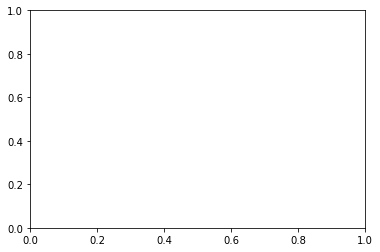

In [47]:
fig,ax = plt.subplots()

In [51]:
bar_container.patches

hi


D:\Anaconda\envs\qaoa\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


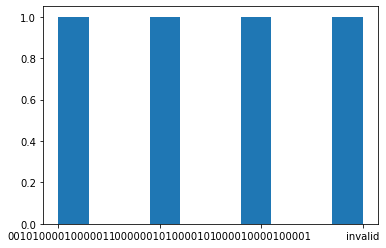

In [90]:
def build_hist():
    plt.figure()
    
    def update_hist(step):
        print('hi')
        #plt.cla()
        data = alternating_operator_counts[step]
        plt.hist(filter_unique_paths(G,data))

update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=50)
plt.show()

In [76]:
len(alternating_operator_counts)

50

hi


D:\Anaconda\envs\qaoa\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


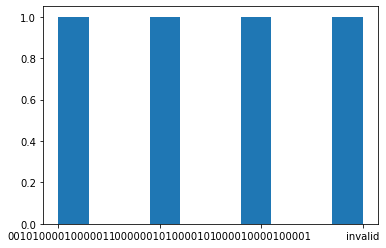

In [89]:
plt.figure()
    
def update_hist(step):
        print('hi')
        #plt.cla()
        data = alternating_operator_counts[step]
        plt.hist(filter_unique_paths(G,data))

update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=50)
plt.show()

In [91]:
build_hist()

<Figure size 432x288 with 0 Axes>

TypeError: '<' not supported between instances of 'Counts' and 'float'

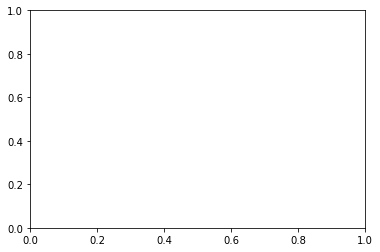

In [70]:
fig,ax = plt.subplots()
_, _, bar_container = ax.hist(alternating_operator_counts)



def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = alternating_operator_counts[frame_number]
        for bitstring_count, rect in zip(data.items(), bar_container.patches):
            print(bitstring_count)
            rect.set_height(bitstring_count[1])
        return bar_container.patches
    return animate

In [69]:
ani = animation.FuncAnimation(fig, prepare_animation(bar_container),
                              repeat=False, blit=True)

('0010100001000001', 59)
('1000000101000010', 63)
('1000001001000001', 147)
('0100100000100001', 154)
('1000010000100001', 353)
('0001100001000010', 29)
('0100100000010010', 61)
('1000010000010010', 158)
('0010100001011101', 200)


In [67]:
plt.show()

In [53]:
for i in a.items():
    print(i)

('0010100001000001', 59)
('1000000101000010', 63)
('1000001001000001', 147)
('0100100000100001', 154)
('1000010000100001', 353)
('0001100001000010', 29)
('0100100000010010', 61)
('1000010000010010', 158)
('0010100001011101', 200)


In [44]:
a['0010100001011101'] = 200

In [45]:
a

{'0010100001000001': 59,
 '1000000101000010': 63,
 '1000001001000001': 147,
 '0100100000100001': 154,
 '1000010000100001': 353,
 '0001100001000010': 29,
 '0100100000010010': 61,
 '1000010000010010': 158,
 '0010100001011101': 200}

In [33]:
a = alternating_operator_counts[0]

In [46]:
filter_unique_paths(G,a)

{'0010100001000001': 371,
 '1000000101000010': 210,
 '1000010000100001': 443,
 'invalid': 200}